**PHUONG NGUYEN NGOC**

Spring 2021

CS 251: Data Analysis and Visualization

Project 6: Supervised learning

In [30]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Task 3: Preprocess full spam email dataset 

Before you build a Naive Bayes spam email classifier, run the full spam email dataset through your preprocessing code.

Download and extract the full **Enron** emails (*zip file should be ~29MB large*). You should see a base `enron` folder, with `spam` and `ham` subfolders when you extract the zip file (these are the 2 classes).

Run the test code below to check everything over.

### 3a) Preprocess dataset

In [2]:
import email_preprocessor as epp

#### Test `count_words` and `find_top_words`

In [3]:
word_freq, num_emails = epp.count_words()

In [4]:
print(f'You found {num_emails} emails in the datset. You should have found 32625.')

You found 32625 emails in the datset. You should have found 32625.


In [5]:
top_words, top_counts = epp.find_top_words(word_freq)
print(f"Your top 5 words are\n{top_words[:5]}\nand they should be\n['the', 'to', 'and', 'of', 'a']")
print(f"The associated counts are\n{top_counts[:5]}\nand they should be\n[277459, 203659, 148873, 139578, 111796]")

Your top 5 words are
['the', 'to', 'and', 'of', 'a']
and they should be
['the', 'to', 'and', 'of', 'a']
The associated counts are
[277459, 203659, 148873, 139578, 111796]
and they should be
[277459, 203659, 148873, 139578, 111796]


### 3b) Make train and test splits of the dataset

Here we divide the email features into a 80/20 train/test split (80% of data used to train the supervised learning model, 20% we withhold and use for testing / prediction).

In [6]:
features, y = epp.make_feature_vectors(top_words, num_emails)
np.random.seed(0)
x_train, y_train, inds_train, x_test, y_test, inds_test = epp.make_train_test_sets(features, y)

In [7]:
print('Shapes for train/test splits:')
print(f'Train {x_train.shape}, classes {y_train.shape}')
print(f'Test {x_test.shape}, classes {y_test.shape}')
print('\nThey should be:\nTrain (26100, 200), classes (26100,)\nTest (6525, 200), classes (6525,)')

Shapes for train/test splits:
Train (26100, 200), classes (26100,)
Test (6525, 200), classes (6525,)

They should be:
Train (26100, 200), classes (26100,)
Test (6525, 200), classes (6525,)


### 3c) Save data in binary format

It add a lot of overhead to have to run through your raw email -> train/test feature split every time you wanted to work on your project! In this step, you will export the data in memory to disk in a binary format. That way, you can quickly load all the data back into memory (directly in ndarray format) whenever you want to work with it again. No need to parse from text files!

- Use numpy's `save` function to make six files in `.npy` format (e.g. `email_train_x.npy`, `email_train_y.npy`, `email_train_inds.npy`, `email_test_x.npy`, `email_test_y.npy`, `email_test_inds.npy`).

In [8]:
np.save('data/email_train_x.npy',x_train)
np.save('data/email_train_y.npy',y_train)
np.save('data/email_train_inds.npy',inds_train)
np.save('data/email_test_x.npy',x_test)
np.save('data/email_test_y.npy',y_test)
np.save('data/email_test_inds.npy',inds_test)

## Task 4: Naive Bayes Classifier

After finishing your email preprocessing pipeline, implement the one other supervised learning algorithm we we will use to classify email, **Naive Bayes**.

### 4a) Implement Naive Bayes

In `naive_bayes.py`, implement the following methods:
- Constructor
- `train(data, y)`: Train the Naive Bayes classifier so that it records the "statistics" of the training set: class priors (i.e. how likely an email is in the training set to be spam or ham?) and the class likelihoods (the probability of a word appearing in each class — spam or ham).
- `predict(data)`: Combine the class likelihoods and priors to compute the posterior distribution. The predicted class for a test sample is the class that yields the highest posterior probability.
- `accuracy(y, y_pred)`: The usual definition :)


#### Bayes rule ingredients: Priors and likelihood (`train`)

To compute class predictions (probability that a test example belong to either spam or ham classes), we need to evaluate **Bayes Rule**. This means computing the priors and likelihoods based on the training data.

**Prior:** $$P_c = \frac{N_c}{N}$$ where $P_c$ is the prior for class $c$ (spam or ham), $N_c$ is the number of training samples that belong to class $c$ and $N$ is the total number of training samples.

**Likelihood:** $$L_{c,w} = \frac{N_{c,w} + 1}{N_{c} + M}$$ where
- $L_{c,w}$ is the likelihood that word $w$ belongs to class $c$ (*i.e. what we are solving for*)
- $N_{c,w}$ is the total count of **word $w$** in emails that are only in class $c$ (*either spam or ham*)
- $N_{c}$ is the total number of **all words** that appear in emails of the class $c$ (*total number of words in all spam emails or total number of words in all ham emails*)
- $M$ is the number of features (*number of top words*).

#### Bayes rule ingredients: Posterior (`predict`)

To make predictions, we now combine the prior and likelihood to get the posterior:

**Log Posterior:** $$Log(\text{Post}_{i, c}) = Log(P_c) + \sum_{j \in J_i}x_{i,j}Log(L_{c,j})$$

 where
- $\text{Post}_{i,c}$ is the posterior for class $c$ for test sample $i$(*i.e. evidence that email $i$ is spam or ham*). We solve for its logarithm.
- $Log(P_c)$ is the logarithm of the prior for class $c$.
- $x_{i,j}$ is the number of times the jth word appears in the ith email.
- $Log(L_{c,j})$: is the log-likelihood of the jth word in class $c$.

In [9]:
from naive_bayes_multinomial import NaiveBayes

#### Test `train`

In [10]:
num_test_classes = 4
np.random.seed(0)
data_test = np.random.random(size=(100, 6))
y_test = np.random.randint(low=0, high=num_test_classes, size=(100,))

nbc = NaiveBayes(num_classes=num_test_classes)
nbc.train(data_test, y_test)

print(f'Your class priors are: {nbc.class_priors}\nand should be          [0.24 0.26 0.25 0.25].')
print(f'Your class likelihoods shape is {nbc.class_likelihoods.shape} and should be (4, 6).')
print(f'Your likelihoods are:\n{nbc.class_likelihoods}')


test_likelihoods = np.array([[0.15116, 0.18497, 0.17571, 0.1463 , 0.16813, 0.17374],
       [0.16695, 0.17437, 0.15742, 0.16887, 0.15677, 0.17562],
       [0.14116, 0.1562 , 0.19651, 0.17046, 0.17951, 0.15617],
       [0.18677, 0.18231, 0.15884, 0.12265, 0.16755, 0.18187]])
print(f'and should be\n{test_likelihoods}')

Your class priors are: [0.24 0.26 0.25 0.25]
and should be          [0.24 0.26 0.25 0.25].
Your class likelihoods shape is (4, 6) and should be (4, 6).
Your likelihoods are:
[[0.15116 0.18497 0.17571 0.1463  0.16813 0.17374]
 [0.16695 0.17437 0.15742 0.16887 0.15677 0.17562]
 [0.14116 0.1562  0.19651 0.17046 0.17951 0.15617]
 [0.18677 0.18231 0.15884 0.12265 0.16755 0.18187]]
and should be
[[0.15116 0.18497 0.17571 0.1463  0.16813 0.17374]
 [0.16695 0.17437 0.15742 0.16887 0.15677 0.17562]
 [0.14116 0.1562  0.19651 0.17046 0.17951 0.15617]
 [0.18677 0.18231 0.15884 0.12265 0.16755 0.18187]]


#### Test `predict`

In [11]:
num_test_classes = 4
np.random.seed(0)
data_train = np.random.randint(low=0, high=num_test_classes, size=(100, 10))
data_test = np.random.randint(low=0, high=num_test_classes, size=(15, 10))
y_test = np.random.randint(low=0, high=num_test_classes, size=(100,))

nbc = NaiveBayes(num_classes=num_test_classes)
nbc.train(data_train, y_test)
test_y_pred = nbc.predict(data_test)
test_y = np.array([3,0,3,1,0,1,1,3,0,3,0,2,0,2,1])

print(f'Your predicted classes are\n{test_y_pred}\nand should be\n[3 0 3 1 0 1 1 3 0 3 0 2 0 2 1]')

Your predicted classes are
[3 0 3 1 0 1 1 3 0 3 0 2 0 2 1]
and should be
[3 0 3 1 0 1 1 3 0 3 0 2 0 2 1]


### 4b) Spam filtering

Let's start classifying spam email using the Naive Bayes classifier.

- Use `np.load` to load in the train/test split that you created last week.
- Use your Naive Bayes classifier on the Enron email dataset!

**Question 7:** Print out the accuracy that you get on the test set with Naive Bayes. It should be roughly 89%.

In [12]:
import email_preprocessor as ep
x_train = np.load('data/email_train_x.npy')
y_train = np.load('data/email_train_y.npy')
inds_train = np.load('data/email_train_inds.npy')
x_test = np.load('data/email_test_x.npy')
y_test = np.load('data/email_test_y.npy')
inds_test = np.load('data/email_test_inds.npy')


In [13]:
email_naive_bayes = NaiveBayes(num_classes=2)
email_naive_bayes.train(x_train,y_train)

In [14]:
y_pred = email_naive_bayes.predict(x_test)
acc = email_naive_bayes.accuracy(y_test, y_pred)
print(f'Accuracy on test set {acc}')

Accuracy on test set 0.8924137931034483


### 4c) Confusion matrix

To get a better sense of the errors that the Naive Bayes classifer makes, you will create a confusion matrix. 

- Implement `confusion_matrix` in `naive_bayes.py`.
- Print out a confusion matrix of the spam classification results.

**Debugging guidelines**:
1. The sum of all numbers in your 2x2 confusion matrix should equal the number of test samples (6525).
2. The sum of your spam row should equal the number of spam samples in the test set (3193)
3. The sum of your ham row should equal the number of spam samples in the test set (3332)

In [15]:
email_confusion_matrix = email_naive_bayes.confusion_matrix(y_test, y_pred)
print("Label: [ham, spam]")
print(f'Confusion matrix:\n{email_confusion_matrix}')

Label: [ham, spam]
Confusion matrix:
[[2780.  552.]
 [ 150. 3043.]]


**Question 8:** Interpret the confusion matrix, using the convention that positive detection means spam (*e.g. a false positive means classifying a ham email as spam*). What types of errors are made more frequently by the classifier? What does this mean (*i.e. X (spam/ham) is more likely to be classified than Y (spam/ham) than the other way around*)?

**Reminder:** Look back and make sure you are clear on which class indices correspond to spam/ham.

**Answer 8:**
False positive errors are made more frequently by the classifiers than fasle negative. This means that ham is more likely to be classified as spam than the other way around.

### 4d) Investigate the misclassification errors

Numbers are nice, but they may not the best for developing your intuition. Sometimes, you want to see what an misclassification *actually looks like* to help you improve your algorithm. Here, you will take a false positive and a false negative misclassification and retrieve the actual text of the email so see which emails produced the error.

- Determine the index of the **FIRST** false positive and false negative misclassification — i.e. 2 indices in total. Remember to use your `test_inds` array to look up the index of the emails BEFORE shuffling happened.
- Implement the function `retrieve_emails` in `email_preprocessor.py` to return the string of the raw email at the error indices.
- Call your function to print out the two emails that produced misclassifications.

In [140]:
# first false positive email
gt_N = np.where(y_test == 0)[0] # list of index of items labeled 0
pred_P = y_pred[np.ix_(gt_N)] #prediction of items labeled 0
FP = np.where(pred_P == 1)[0] # list of index of items labeled 0 but predicted as 1 in the prediction list of items labeled 0
ori_first_FP = inds_test[gt_N[FP[0]]]

# first false negative email
gt_P = np.where(y_test == 1)[0] # list of index of items labeled 1
pred_N = y_pred[np.ix_(gt_P)] #prediction of items labeled 1
FN = np.where(pred_N == 0)[0] # list of index of items labeled 1 but predicted as 0 in the prediction list of items labeled 1
ori_first_FN = inds_test[gt_P[FN[0]]]

contents = epp.retrieve_emails([ori_first_FP, ori_first_FN])
print('first false positive email:')
print(contents[0])
print('\n')
print('first false negative email:')
print(contents[1])


first false positive email:
Subject: schedule
well , this season we lost mick and o ' neal and picked up daren and plove . i guess i ' ll be on the court more to utilize my quickness since we lost a couple of guards . we have a buy next week to open the season .


first false negative email:
Subject: re : mail authentification
bad gateway : the message has been attached .
+ + + attachment : no virus found
+ + + panda antivirus - www . pandasoftware . com



**Question 9:** Does it seem reasonable that each email message was misclassified? Why?

**Answer 9:** 
- The false positive email contains words such as "buy next week to open the season," which sounds pretty similar to an advertisement, so it is reasonable that the email was misclassified.
- The false negative email seems to have the contain of a normal informative email the replies to a mail authentification request, so it is reasonable that the email was misclassified.

## Task 5: Comparison with KNN


- Run a similar analysis to what you did with Naive Bayes above. When computing accuracy on the test set, you may want to reduce the size of the test set (e.g. to the first 500 emails in the test set).
- Copy-paste your `confusion_matrix` method into `knn.py` so that you can run the same analysis on a KNN classifier.

In [24]:
from knn import KNN

In [112]:
email_knn = KNN(2)
start = time.time()
email_knn.train(x_train, y_train)
knn_y_pred = email_knn.predict(x_test[:500], 5)
time_cost_L2 = time.time() - start
knn_acc = email_knn.accuracy(y_test[:500], knn_y_pred)
knn_cm = email_knn.confusion_matrix(y_test[:500], knn_y_pred)
print(f"Accuracy with KNN: {knn_acc}")
print(f"Confusion matrix \n {knn_cm}")
print(f'Training and Prediction time: {time_cost_L2}')

time for one L2 distance computation: 0.07132387161254883
Accuracy with KNN: 0.922
Confusion matrix 
 [[211.  22.]
 [ 17. 250.]]
Training and Prediction time: 13.19335126876831


In [37]:
start = time.time()
reduced_email_nb = NaiveBayes(num_classes=2)
reduced_email_nb.train(x_train[:500],y_train[:500])
nb_y_pred = reduced_email_nb.predict(x_test[:500])
time_cost_nb = time.time() - start
nb_acc = reduced_email_nb.accuracy(y_test[:500], nb_y_pred)
nb_cm = reduced_email_nb.confusion_matrix(y_test[:500], nb_y_pred)
print(f"Accuracy with Naive Bayes: {nb_acc}")
print(f"Confusion matrix \n {nb_cm}")
print(f'Training and Prediction time: {time_cost_nb}')


Accuracy with Naive Bayes: 0.84
Confusion matrix 
 [[162.  71.]
 [  9. 258.]]
Training and Prediction time: 0.0013031959533691406


**Question 10:** What accuracy did you get on the test set (potentially reduced in size)?

**Question 11:** How does the confusion matrix compare to that obtained by Naive Bayes (*If you reduced the test set size, keep that in mind*)?

**Question 12:** Briefly describe at least one pro/con of KNN compared to Naive Bayes on this dataset.

**Question 13:** When potentially reducing the size of the test set here, why is it important that we shuffled our train and test set?

**Answer 10:**
I get accuracy of 0.922 on the reduced test set with KNN classifier and 0.84 with Naive Bayes classifier

**Answer 11:** 
The KNN confusion matrix has more entries on the main diagonal and fewer entries at other positions than the Naive Bayes confusion matrix

**Answer 12:** 
Pro: KNN classifier is more accurate than Naive Bayes classifier. (accuracy: 0.922 vs. 0.84)
Con: KNN classifier takes much longer than Naive Bayes classifier. (prediction time: 15.965 vs. 0.001)

**Answer 13:** 
If we do not suffle the train and test set, there is a possibility that our training set will not contain any data sample of a class because the data are initially grouped by class. This will result in failure in prediction for this missing class.

## Extensions

### 0. Classify your own datasets

- Find datasets that you find interesting and run classification on them using your KNN algorithm (and if applicable, Naive Bayes). Analysis the performance of your classifer.

I created a fruit image classifier for this extension. I got the data here https://www.kaggle.com/moltean/fruits. This contains cropped images of hundreds kinds of fruits sized 100x100, grouped in folders equivalent to the fruit name. I decided to only train my model to classify banana, orange, and peach, each of which contains approximaltely 490 data samples. 

Before running the classifier on the data, we need to preprocess the raw images first. I resize the image to size 64x64, turn them into grayscale, then label them. Then I generate a shuffled train and test set. 

To lessen the computational burden, I perform PCA on the train dataset, decide on the number of PC to keep = 20, and project the train dataset on the PCA space. I also center the test dataset then project it to the PCA space of the train dataset

In [38]:
import image_processor as ipp
fruit_features, fruit_y, num_fruits = ipp.preprocess_directory("data/fruit")

In [39]:
print(f'Number of data samples: {num_fruits}')

Number of data samples: 1461


In [40]:
from pca_cov import PCA_COV
import pandas as pd

fruit_x_train, fruit_y_train, fruit_inds_train, fruit_x_test, fruit_y_test, fruit_inds_test = ipp.make_train_test_sets(fruit_features, fruit_y)
# fruit_pca = ipp.PCA_perform(fruit_x_train, 10)

df = pd.DataFrame(data=fruit_x_train)

image_pca = PCA_COV(df)
vars_list = [i for i in range(len(df.columns))]
start_pca = time.time()
image_pca.pca(vars_list)
print(f'Performing PCA takes {time.time() - start_pca}s')

# return image_pca



Performing PCA takes 754.9907238483429s


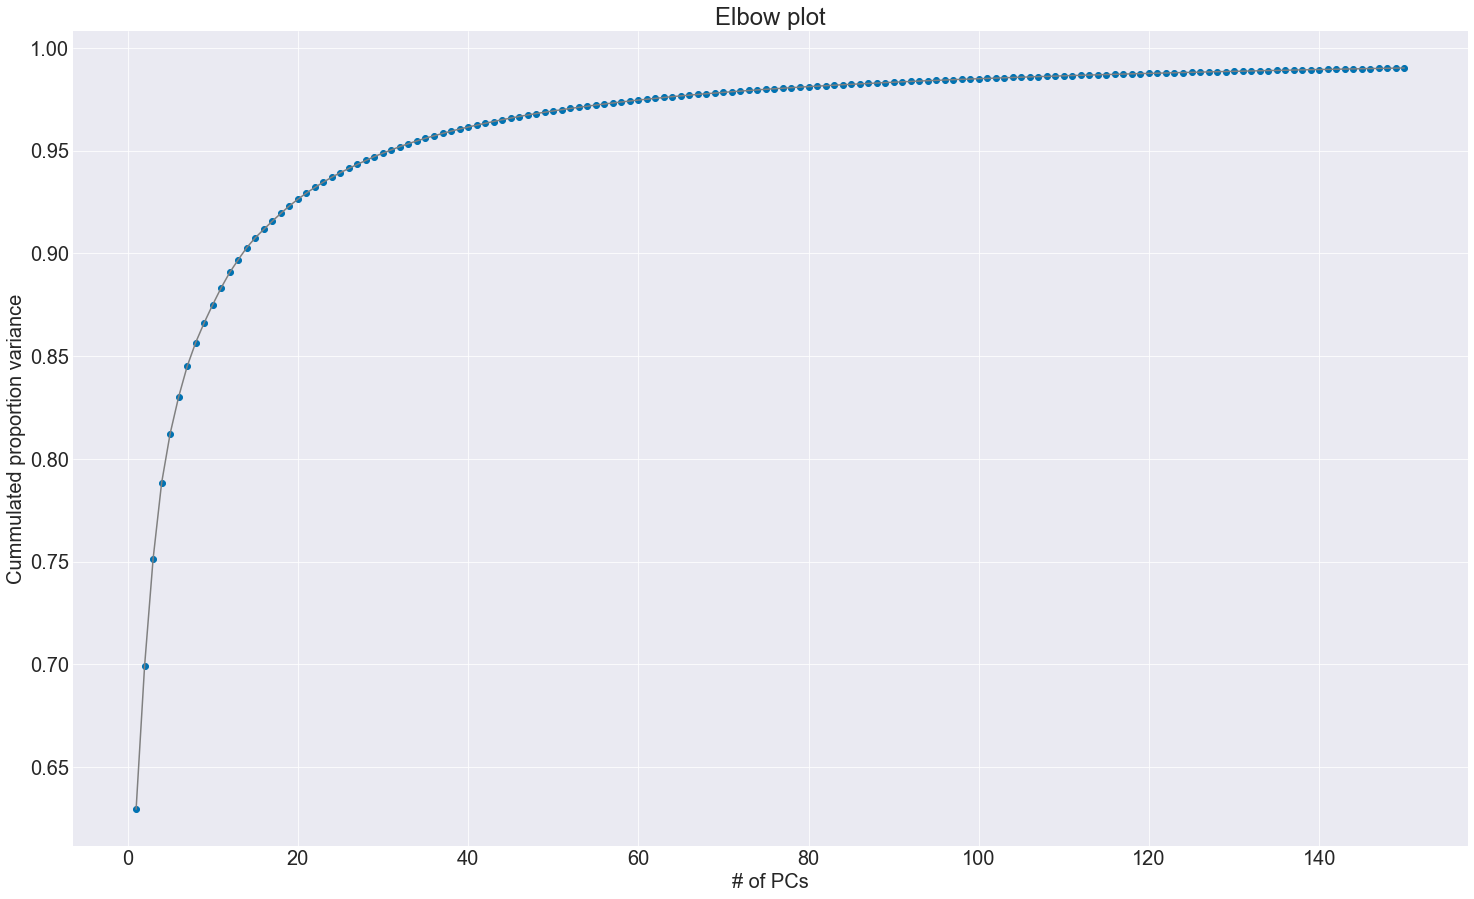

In [44]:
image_pca.elbow_plot(150)
plt.show()

In [42]:
number_of_pcs = 20
mean_fruit = np.mean(fruit_x_train,axis=0)
pca_fruit_x_train = ipp.PCA_project(image_pca,[i for i in range(number_of_pcs)])
pca_fruit_x_test = (fruit_x_test-mean_fruit)@image_pca.e_vecs[:, :number_of_pcs]

In [43]:
print(pca_fruit_x_train.shape)
print(fruit_y_train.shape)
print(pca_fruit_x_test.shape)
print(fruit_y_test.shape)

(1168, 20)
(1168,)
(293, 20)
(293,)


In [108]:
fruit_knn = KNN(num_classes=3)
fruit_knn.train(pca_fruit_x_train, fruit_y_train)
fruit_y_pred = fruit_knn.predict(pca_fruit_x_test, 1)
fruit_acc = fruit_knn.accuracy(fruit_y_test, fruit_y_pred)
print(f'Accuracy of fruit image classification: {fruit_acc}')

Accuracy of fruit image classification: 1.0


The classifier yeilds very positive result. Investigating the dataset, we can see that part of this absolute accuracy must be attributed to how clean the dataset it. The images are of the same size with white background, which help eleiminate a lot of noisy factor. In the same class, the images are basically different angles of the fruits, so the training set has an abundance of shapes for a single type of fruit and a high consistency in color, even though the image is grayscaled (we can still see the lighter and darker shade in the images). Across classes, the images of different fruits are clearly differentiable in color. The shapes are also very distinguishable in the way that, for example, different shapes of bananas do not appear or take any resemblance to any image of the other two classes. This makes it very easy to find an image or several images in the training set that have high degree of similarity to and belong to the same class as an image in the test set, so it is almost impossible to misclassify.

Below are some photos of each class in test set and training set:

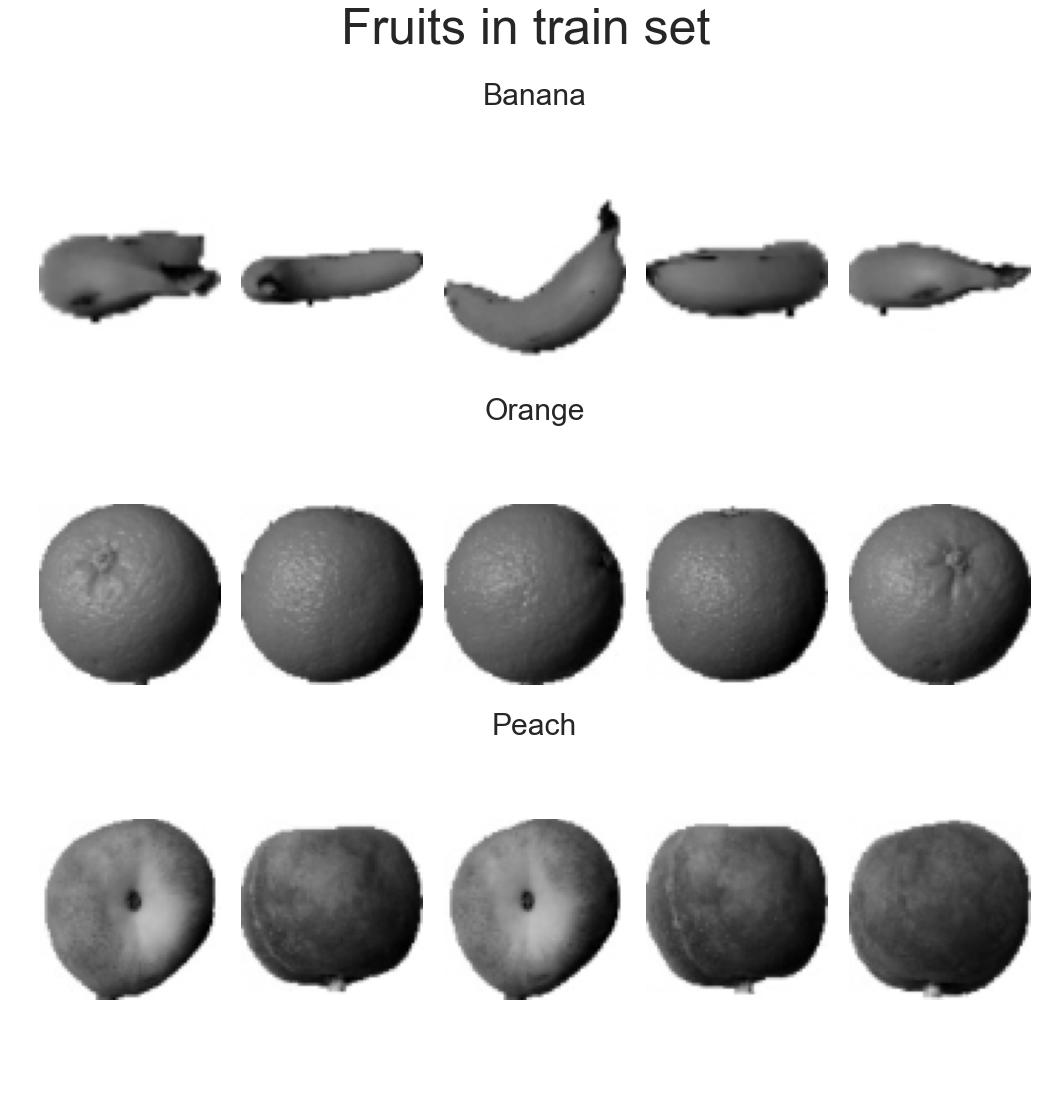

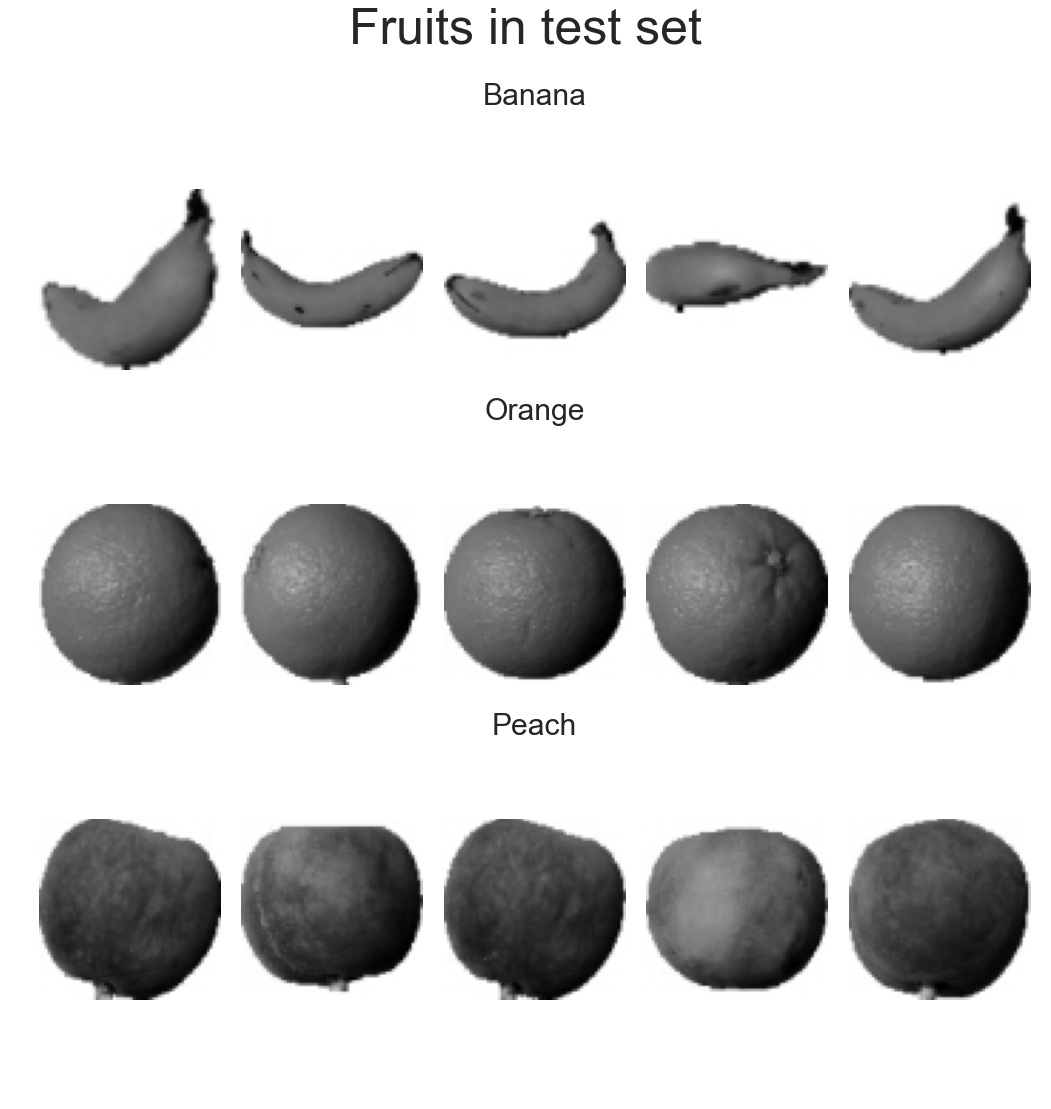

In [93]:
fruit_plot_train = np.zeros((15, fruit_x_train.shape[1]))
fruit_plot_train[:5] = fruit_x_train[np.where(fruit_y_train==0)[0][:5]]
fruit_plot_train[5:10] = fruit_x_train[np.where(fruit_y_train==1)[0][:5]]
fruit_plot_train[10:15] = fruit_x_train[np.where(fruit_y_train==2)[0][:5]]
# ipp.plot_25_images(fruit_plot_train, "Fruits in train set")

fruit_plot_test = np.zeros((15, fruit_x_train.shape[1]))
fruit_plot_test[:5] = fruit_x_test[np.where(fruit_y_test==0)[0][:5]]
fruit_plot_test[5:10] = fruit_x_test[np.where(fruit_y_test==1)[0][:5]]
fruit_plot_test[10:15] = fruit_x_test[np.where(fruit_y_test==2)[0][:5]]
# ipp.plot_25_images(fruit_plot_test, "Fruits in test set")




ipp.plot_images(fruit_plot_train, ["Banana", "Orange", "Peach"], 3, 5, "Fruits in train set")
ipp.plot_images(fruit_plot_test, ["Banana", "Orange", "Peach"], 3, 5, "Fruits in test set")

### 1. Better text preprocessing

- If you look at the top words extracted from the email dataset, many of them are common "stop words" (e.g. a, the, to, etc.) that do not carry much meaning when it comes to differentiating between spam vs. non-spam email. Improve your preprocessing pipeline by building your top words without stop words. Analyze performance differences.

In [97]:
n_stop_words = 10
print(f'Added words: {top_words_no_stop[-n_stop_words:]}\n')
print(f'Eliminated words: {top_words[:n_stop_words]}')

Added words: ['find', 'current', 'phone', 'down', 'does', 'monday', 'team', 'buy', 'request', 'change']

Eliminated words: ['the', 'to', 'and', 'of', 'a', 'in', 'for', 'you', 'is', 'enron']


From my observation, I found that common "stop words" are generally the most frequent words. Therefore, I experimented with dropping n most frequent words and adding the next n most frequent words after the first 200 features. 

I began with 10 most common words, then increased by 10 after each iteration, and ended up with 100 first words being eliminated. As we can see, the 201st to 210th most frequent words in place of the 10 most frequent words, which may not contribute much to the content of the email, gives us words with more meaning. Hopefully this modification can improve the accuracy of the classifier.

In [85]:
no_stop_features, no_stop_y = epp.make_feature_vectors(top_words_no_stop, num_emails)
np.random.seed(0)
no_stop_x_train, no_stop_y_train, no_stop_inds_train, no_stop_x_test, no_stop_y_test, no_stop_inds_test = epp.make_train_test_sets(no_stop_features, no_stop_y)

In [102]:
n_stop_words = np.zeros(10)
nb_stop_words_accs = np.zeros(10)
no_stop_email_naive_bayes = NaiveBayes(num_classes=2)
cursor = 0
for i in range(0, 100, 10):
    top_words_no_stop, top_counts_no_stop = epp.find_top_words_without_stop_words(word_freq,200,i+10)
    no_stop_features, no_stop_y = epp.make_feature_vectors(top_words_no_stop, num_emails)
    np.random.seed(0)
    no_stop_x_train, no_stop_y_train, no_stop_inds_train, no_stop_x_test, no_stop_y_test, no_stop_inds_test = epp.make_train_test_sets(no_stop_features, no_stop_y)
    
    no_stop_email_naive_bayes.train(no_stop_x_train,no_stop_y_train)
    nb_no_stop_y_pred = no_stop_email_naive_bayes.predict(no_stop_x_test)
    nb_no_stop_acc = no_stop_email_naive_bayes.accuracy(no_stop_y_test, nb_no_stop_y_pred)
    
    n_stop_words[cursor] = i+10
    nb_stop_words_accs[cursor] = nb_no_stop_acc
    cursor += 1
    print(f'Number stop words: {i+10} - Naive Bayes Accuracy: {nb_no_stop_acc}')

Number stop words: 10 - Naive Bayes Accuracy: 0.88
Number stop words: 20 - Naive Bayes Accuracy: 0.8737164750957854
Number stop words: 30 - Naive Bayes Accuracy: 0.8931800766283525
Number stop words: 40 - Naive Bayes Accuracy: 0.8957854406130268
Number stop words: 50 - Naive Bayes Accuracy: 0.8983908045977012
Number stop words: 60 - Naive Bayes Accuracy: 0.9008429118773946
Number stop words: 70 - Naive Bayes Accuracy: 0.9026819923371647
Number stop words: 80 - Naive Bayes Accuracy: 0.8948659003831417
Number stop words: 90 - Naive Bayes Accuracy: 0.8859770114942529
Number stop words: 100 - Naive Bayes Accuracy: 0.8807662835249043


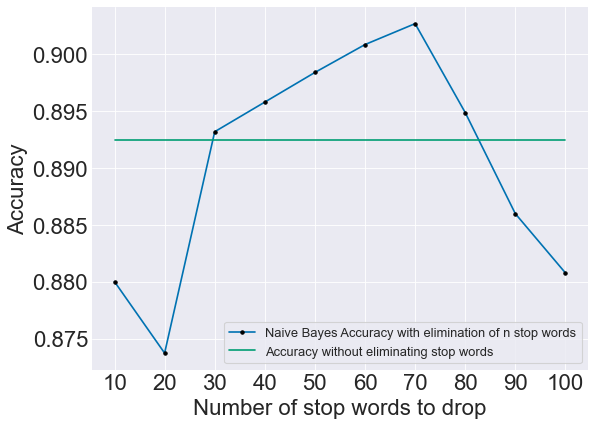

In [103]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(n_stop_words, nb_stop_words_accs, label="Naive Bayes Accuracy with elimination of n stop words",marker=".",mfc="#000000", mec="#000000")
plt.plot(np.arange(10,110, 10), np.ones(10)*acc, label="Accuracy without eliminating stop words")
plt.xticks(np.arange(10,110, 10))
plt.xlabel("Number of stop words to drop")
plt.ylabel("Accuracy")
plt.legend(fontsize="xx-small",frameon=True)
plt.show()

We can see that dropping the stop words does not necessary increase the accuracy of the classifiers. With the elimination of the first 10, 20, 90, and 100 words, the accuracy actually decrease, while for other number of dropped words, the accuracy rose but not to a great extent. The peak of accuracy is only slightly above 0.9, which is not so impressive an improvement from the 0.892 accuracy without dropping any stop words. This may suggest that the stop words, despite their being common, may have a certain effect on the content of the email, given the difference in their frequency. 

### 2. Feature size

- Explore how the number of selected features for the email dataset influences accuracy and runtime performance.

I tried different feature sizes, starting with 100 and ending with 1000 to see how well the accuracy is improved and whether the trade off between accuracy and time is worth.

In [104]:
import time
n_features = np.zeros(10)
n_accs = np.zeros(10)
n_times = np.zeros(10)
cursor = 0
for i in range(0, 1000, 100):
    n_top_words, n_top_counts = epp.find_top_words(word_freq,i+100)
    n_feature, n_y = epp.make_feature_vectors(n_top_words, num_emails)
    np.random.seed(0)
    n_x_train, n_y_train, n_inds_train, n_x_test, n_y_test, n_inds_test = epp.make_train_test_sets(n_feature, n_y)
    nb = NaiveBayes(num_classes=2)
    start = time.time()
    nb.train(n_x_train,n_y_train)
    n_y_pred = nb.predict(n_x_test)
    n_acc = nb.accuracy(n_y_test, n_y_pred)
    n_time = time.time() - start
    print(f'Number of features: {i+100} - Accuracy: {n_acc} - Time: {n_time}')
    n_features[cursor] = i+100
    n_accs[cursor] = n_acc
    n_times[cursor] = n_time
    cursor += 1


Number of features: 100 - Accuracy: 0.8367816091954023 - Time: 0.038633108139038086
Number of features: 200 - Accuracy: 0.8924137931034483 - Time: 0.03685593605041504
Number of features: 300 - Accuracy: 0.9203065134099617 - Time: 0.05271410942077637
Number of features: 400 - Accuracy: 0.9348659003831418 - Time: 0.07084226608276367
Number of features: 500 - Accuracy: 0.9411494252873563 - Time: 0.1149137020111084
Number of features: 600 - Accuracy: 0.9446743295019157 - Time: 0.12534499168395996
Number of features: 700 - Accuracy: 0.9485057471264368 - Time: 0.1415410041809082
Number of features: 800 - Accuracy: 0.9508045977011494 - Time: 0.20229721069335938
Number of features: 900 - Accuracy: 0.9552490421455939 - Time: 0.17274093627929688
Number of features: 1000 - Accuracy: 0.9581609195402299 - Time: 0.21120214462280273


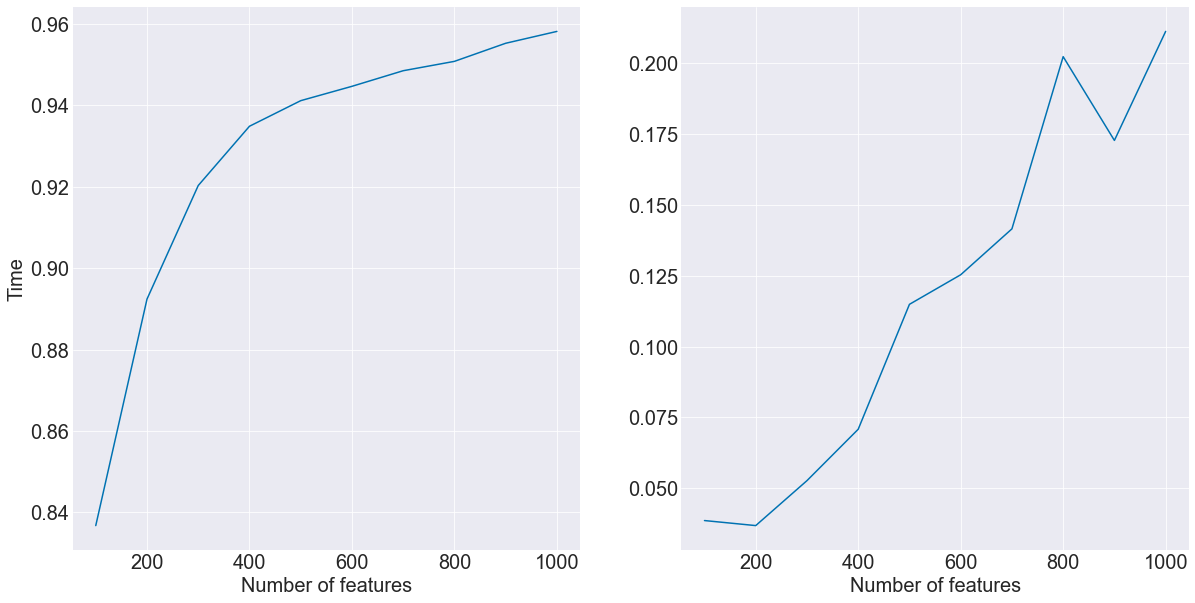

In [107]:
fig, ax = plt.subplots(1,2,sharex='col',figsize=(20, 10))
# n_features.shape
ax[0].plot(n_features, n_accs)
ax[0].set_xlabel("Number of features")
ax[0].set_ylabel("Accuracy")
ax[1].plot(n_features, n_times)
ax[1].set_xlabel("Number of features")
ax[0].set_ylabel("Time")
plt.show()

We can see that the accuracy increases at a decreasing speed, while time generally increases at a relatively abnormal rate (positive rate until 500 features, then negative rate untill 700 features,...) as we increase the feature size. However, the computational time for Naive Bayes classifier is pretty minimal, so the extra toll is not that corncerning. Meanwhile, the accuracy appears to converge from 400 features, which takes about 0.07s to process. I would say that 400 features is the optimal size, considering the accuracy and time.

### 3. Distance metrics
- Compare KNN performance with the $L^2$ and $L^1$ distance metrics

In the KNN class, I write a method named predict_L1, which computes L1 distance instead of L2 distance for the prediction. I use this method to classify the first 500 emails in the test set and compare the result with the performance of the original predict method which uses L2 distance.

In [113]:
start = time.time()
y_pred_L1 = email_knn.predict_L1(x_test[:500], 5) 
time_cost_L1 = time.time() - start
acc_L1 = email_knn.accuracy(y_test[:500], y_pred_L1)

time for one L1 distance computation: 0.021759986877441406


In [114]:
print(f'L1 distance:\nAccuracy on test set {acc_L1}\ntime: {time_cost_L1}')
print(f'L2 distance:\nAccuracy on test set {knn_acc}\ntime: {time_cost_L2}')

L1 distance:
Accuracy on test set 0.938
time: 13.75232195854187
L2 distance:
Accuracy on test set 0.922
time: 13.19335126876831


We can see that using L1 distance yields us slightly better time efficiency and accuracy. To further investigate the difference in time, I printed out the time it takes for one distance computation of each distance metrics. For L2, time for distance computation is approximately 0.071, while it is 0.021 for L1 distance. Given both computation involes np.sum, I think that is because np.absolute takes more time than np.sqrt and np.square. However, it is more possible that the Internet connection as well as the computer disk at the time of running the command may cause the difference, which is not significant anyway. As for the accuracy, it depends on the characteristic of the data. The fact that L1 distance is better on this dataset suggests that the the data points might cluster in a more square, edgy fashion rather than in a sphere.

### 4. K-Fold Cross-Validation

- Research this technique and apply it to data and your KNN and/or Naive Bayes classifiers.

K-Fold Cross-Validation is a common technique that is used in evaluating the effectvieness of the model and hyperparameter tuning, in colaboration with grid search or random search. To evaluate our algorithm, we divide the dataset in to k set. Then we iteratively dedicate one out of k sets to the test set, and train our model on the rest. Eventually, each set is tested once and contributes to the training set k-1 times. The performance after each training then testing is recorded. This process gives us a better understanding and assessment of the performance of the algorithm by decreasing the chance that we base our assessment on the result of an easier test set than normal. More about K-Fold Cross-Validation can be found here https://machinelearningmastery.com/k-fold-cross-validation/

For this experiment, I choose k to be 5, so that the test ratio is the same as our previous training and testing process (test_prop=0.2)

In [122]:
k_fold_nb = NaiveBayes(2)
mean_acc, k_acc = k_fold_nb.k_fold_cross_validation(features, y, 5)
print(f"Accuracy with normal validation: {acc}")
print(f"Average accuracy with k-fold cross-validation: {mean_acc}")
print(f"Accuracy for each fold:\n{k_acc}")

Accuracy with normal validation: 0.8924137931034483
Average accuracy with k-fold cross-validation: 0.8754636015325671
Accuracy for each fold:
[0.91954 0.92582 0.90192 0.81579 0.81425]


With this result, we can see that we have picked a pretty average test set for our normal validation, as the accuracy from that test does not differ much from the average accuracy with k-fold cross-validation (0.892 vs 0.875). Looking into the accuracy for each set using k-fold cross-validation, we can see it fluctuates quite a lot. The lowest accuracy is 0.814, which is over 0.1 less than the highest accuracy 0.925. This shows us the risk of overestimating or underestimating the efficiency of the algorithm when we only evaluate it on one test set.

### 5. Email error analysis

- Dive deeper into the properties of the emails that were misclassified (FP and/or FN) by Naive Bayes or KNN. What is their word composition? How many words were skipped because they were not in the training set? What could plausibly account for the misclassifications?